In [54]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString, box
import random
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd

In [55]:
with open('sample.geojson', 'r', encoding='windows-1251') as f:
    data = json.load(f)

print(json.dumps(data, ensure_ascii=False, indent=4))

{
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            39.787879,
                            57.44876
                        ],
                        [
                            39.789041,
                            57.448078
                        ],
                        [
                            39.794747,
                            57.450329
                        ],
                        [
                            39.791648,
                            57.450982
                        ],
                        [
                            39.787879,
                            57.44876
                        ]
                    ]
                ]
            },
            "properties": {
                "name": "Зона застройки"
            }
     

In [56]:
def Create_gdf(data:dict):

    '''Функция получает на вход данные в формате dict и возвращает геодатасет с размеченными областями'''

    geometries = []
    names = []
    restrictions = []

    for feature in data['features']: # Итерируем по фичам
        geom_type = feature['geometry']['type'] # Тип области
        restriction = feature['properties'].get('restriction', None) # Получаем ограничение на область. Если ограничений нет - None

        if geom_type == 'Polygon': # Для полигонов
            coords = feature['geometry']['coordinates'][0] # Получаем координаты
            polygon = Polygon([(lon, lat) for lon, lat in coords]) # Создаем полигон шейпли по координатам
            geometries.append(polygon) # Тут и ниже - собираем строку для gdf
            names.append(feature['properties']['name'])
            restrictions.append(restriction)
        elif geom_type == 'LineString': # Аналогично для линий
            coords = feature['geometry']['coordinates']
            line = LineString([(lon, lat) for lon, lat in coords])
            geometries.append(line)
            names.append(feature['properties']['name'])
            restrictions.append(restriction)
    res = gpd.GeoDataFrame({'geometry' : geometries, 'name' : names, 'restrictions' : restrictions})

    return res

In [57]:
gdf = Create_gdf(data)
gdf

,geometry,name,restrictions
0,"POLYGON ((39.78788 57.44876, 39.78904 57.44808...",Зона застройки,None
1,"POLYGON ((39.78759 57.45067, 39.78954 57.44924...",Лесная зона,building not allowed
2,"POLYGON ((39.78659 57.44999, 39.78977 57.44868...",Водоем,building not allowed
3,"LINESTRING (39.78752 57.45061, 39.79018 57.450...",Дорога,building not allowed


In [58]:
def Plot_empty(gdf:gpd.GeoDataFrame, width:int=20, height:int=40):

    '''Функция получает на вход датасет в формате GeoDataFrame и отрисовывает зоны, хранящиеся в нем.
    Обязательные полня в датасете:
    geometry - зоны в формате geometry
    name - названия зон
    restrictions - ограничения на строительства
    На выходе строит карту полученных зон'''

    fig, ax = plt.subplots(figsize=(width, height))

    # Собираем зоны. Концептуальный пример, для реальной работы и зон и признаков будет больше, как я думаю
    forest_zone = gdf[(gdf['geometry'].type == 'Polygon') & (gdf['restrictions'].notnull()) & (gdf['name'] == 'Лесная зона')]
    water_zone = gdf[(gdf['geometry'].type == 'Polygon') & (gdf['restrictions'].notnull()) & (gdf['name'] == 'Водоем')]
    building_zone = gdf[(gdf['geometry'].type == 'Polygon') & (gdf['restrictions'].isnull())]
    roads = gdf[gdf['geometry'].type == 'LineString']

    # Плотим зомы
    forest_zone.plot(ax=ax, color='red', edgecolor='black', legend=False, alpha=0.5)
    water_zone.plot(ax=ax, color='blue', edgecolor='black', legend=False, alpha=0.5)
    roads.plot(ax=ax, color='black', linewidth=4, legend=False)
    building_zone.plot(ax=ax, color='lightgreen', edgecolor='black', legend=False, alpha=0.5)

    # Задаем легенду
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label='Лесная зона', markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Водоем', markerfacecolor='blue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Зоны застройки', markerfacecolor='lightgreen', markersize=10),
        plt.Line2D([0], [0], color='black', linewidth=3, label='Дороги')
    ]

    ax.legend(handles=handles)
    ax.set_title('План зон')
    ax.set_xlabel('Долгота')
    ax.set_ylabel('Широта')
    plt.grid()
    plt.show()

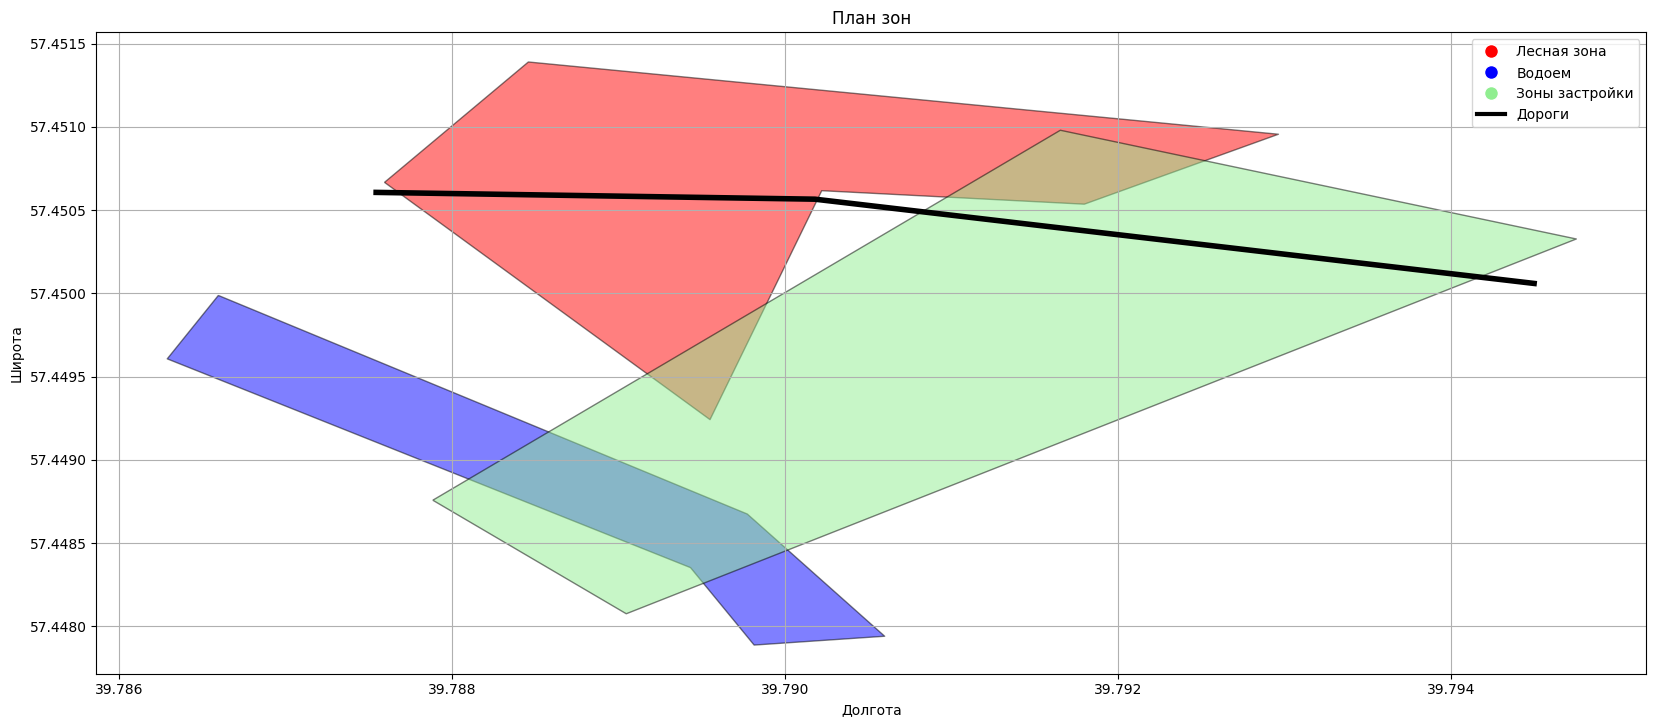

In [59]:
Plot_empty(gdf)

In [65]:
allowed_percent = 0.10
total_area = gdf[gdf['name'] == 'Зона застройки']['geometry'][0]
allowed_area = total_area.area * allowed_percent
restricted_zones = gdf[gdf['name'] != 'Зона застройки']['geometry']

def generate_square_in_polygon(polygon, square_size, restricted_zones, placed_squares):
    while True:
        # Генерируем случайные координаты внутри зоны застройки
        minx, miny, maxx, maxy = polygon.bounds
        x = random.uniform(minx, maxx - square_size) 
        y = random.uniform(miny, maxy - square_size)

        square = box(x, y, x + square_size, y + square_size)

        # Проверяем условия
        if (
            polygon.contains(square) and 
            not restricted_zones.geometry.intersects(square).any() and 
            all(square.distance(placed_square) >= 0.0001 for placed_square in placed_squares)  # Проверяем минимальное расстояние
        ):
            return square

# Параметры квадрата
square_size = 0.0001  # размер стороны квадрата в метрах

squares = []
used_area = 0
placed_squares = []  # Список для хранения размещённых квадратов

while used_area < allowed_area:
    square = generate_square_in_polygon(total_area, square_size, restricted_zones, placed_squares)
    if square:  # Проверяем, был ли успешно сгенерирован квадрат
        squares.append(square)
        placed_squares.append(square)  # Сохраняем размещённый квадрат
        used_area += square.area
    else:
        print("Не удалось разместить квадрат в пределах полигона.")

# Создаем GeoDataFrame для квадратов (если удалось разместить)
squares_gdf = gpd.GeoDataFrame(geometry=squares, crs=gdf.crs)
squares_gdf['name'] = 'Дом'
squares_gdf['restrictions'] = None  # В случае, если для домов нет ограничений

# Объединяем со старым GeoDataFrame
final_gdf = pd.concat([gdf, squares_gdf], ignore_index=True)

# Для подтверждения, можно вывести результат
print(f'{final_gdf}\n{used_area}\n{allowed_area}')


                                             geometry            name  \
0   POLYGON ((39.78788 57.44876, 39.78904 57.44808...  Зона застройки   
1   POLYGON ((39.78759 57.45067, 39.78954 57.44924...     Лесная зона   
2   POLYGON ((39.78659 57.44999, 39.78977 57.44868...          Водоем   
3   LINESTRING (39.78752 57.45061, 39.79018 57.450...          Дорога   
4   POLYGON ((39.79223 57.45004, 39.79223 57.45014...             Дом   
..                                                ...             ...   
79  POLYGON ((39.79201 57.4499, 39.79201 57.45, 39...             Дом   
80  POLYGON ((39.78941 57.44823, 39.78941 57.44833...             Дом   
81  POLYGON ((39.78998 57.44969, 39.78998 57.44979...             Дом   
82  POLYGON ((39.79292 57.45033, 39.79292 57.45043...             Дом   
83  POLYGON ((39.79057 57.44906, 39.79057 57.44916...             Дом   

            restrictions  
0                   None  
1   building not allowed  
2   building not allowed  
3   building no

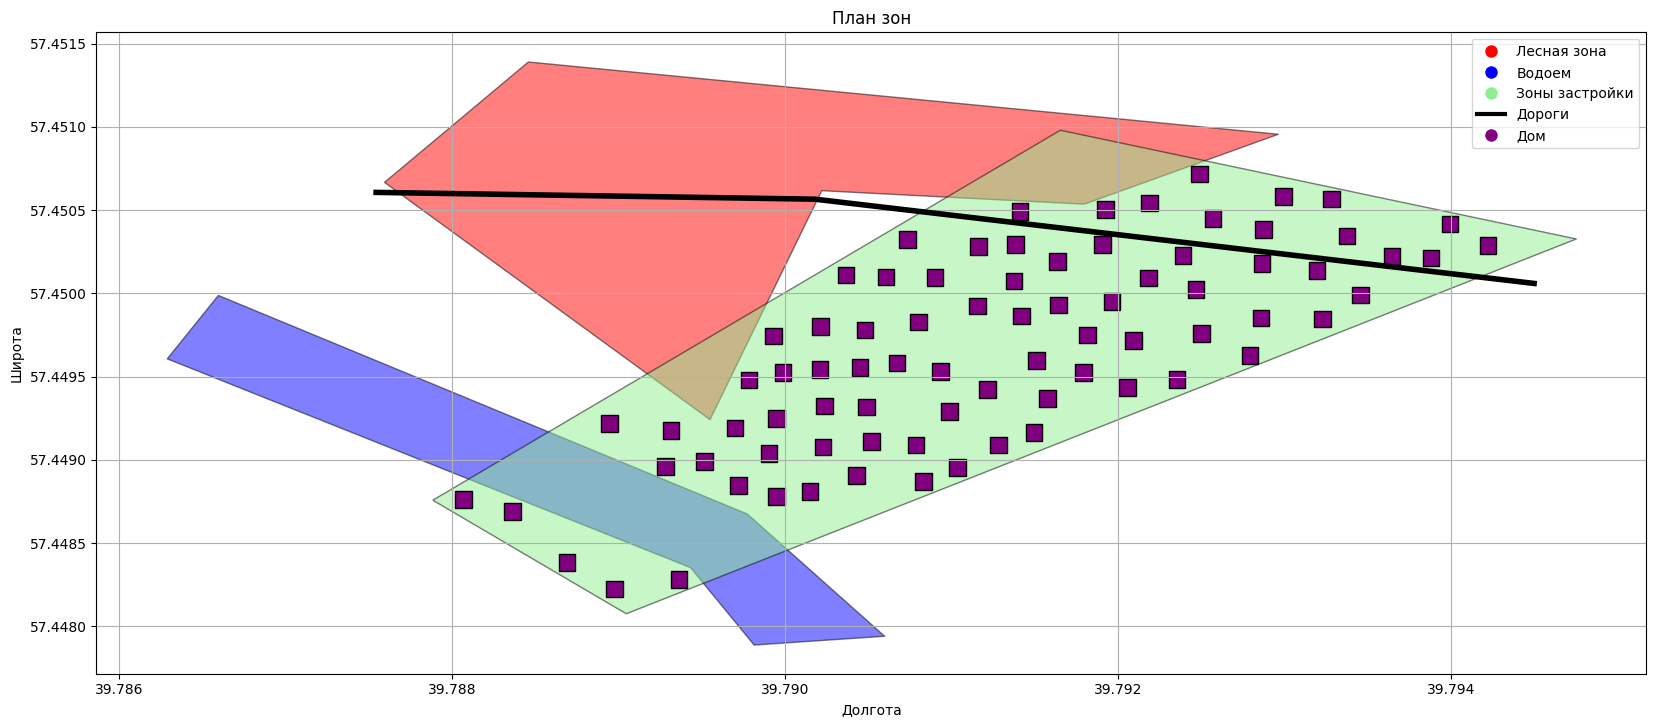

In [66]:
fig, ax = plt.subplots(figsize=(20, 40))

# Собираем зоны. Концептуальный пример, для реальной работы и зон и признаков будет больше, как я думаю
forest_zone = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Лесная зона')]
water_zone = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Водоем')]
building_zone = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Зона застройки')]
roads = final_gdf[final_gdf['geometry'].type == 'LineString']
houses = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Дом')]

# Плотим зомы
forest_zone.plot(ax=ax, color='red', edgecolor='black', legend=False, alpha=0.5)
water_zone.plot(ax=ax, color='blue', edgecolor='black', legend=False, alpha=0.5)
roads.plot(ax=ax, color='black', linewidth=4, legend=False)
building_zone.plot(ax=ax, color='lightgreen', edgecolor='black', legend=False, alpha=0.5)
houses.plot(ax=ax, color='purple', edgecolor='black', legend=False)

# Задаем легенду
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Лесная зона', markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Водоем', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Зоны застройки', markerfacecolor='lightgreen', markersize=10),
    plt.Line2D([0], [0], color='black', linewidth=3, label='Дороги'),
    plt.Line2D([0], [0], marker='o', color='w', label='Дом', markerfacecolor='purple', markersize=10)
]

ax.legend(handles=handles)
ax.set_title('План зон')
ax.set_xlabel('Долгота')
ax.set_ylabel('Широта')
plt.grid()
plt.show()

In [62]:
squares[1].area

1.0000000000663932e-08